# Next-day return prediction for the S&P 500 Index

# Antonio Rosolia

Table of Contents:
* Import Data and Preprocess
* Explorative Data Analysis
* Feature Engineering
* Model
* Feature Importance
* Residual Analysis
* Summary

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ta
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from keras import callbacks
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

sns.set()

Using TensorFlow backend.


## Import Data and Preprocess

In [2]:
data = pd.read_csv("dataset.csv")
data.rename(columns={data.columns[0]: "DATE" }, inplace = True)
data["DATE"] = pd.to_datetime(data["DATE"], format="%d/%m/%Y")
data.set_index("DATE", inplace=True, drop=True)
data.head()

,VOLUME,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
1993-01-29,1003200.0,43.968916,43.968961,43.749988,43.937492
1993-02-01,480500.0,43.968944,44.249887,43.968655,44.250101
1993-02-02,201300.0,44.218879,44.374910,44.124961,44.343823
1993-02-03,529400.0,44.406412,44.843856,44.375026,312.672265
1993-02-04,531500.0,44.968638,45.093704,44.874975,44.999975


### Data Checks

First, let's check if there are any NaNs in the data

In [3]:
data[data.isna().any(axis=1)]

,VOLUME,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
1993-02-15,NaN,NaN,NaN,NaN,NaN
1993-04-09,NaN,NaN,NaN,NaN,NaN
1993-05-31,NaN,NaN,NaN,NaN,NaN
1993-07-05,NaN,NaN,NaN,NaN,NaN
1993-09-06,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2018-07-04,NaN,NaN,NaN,NaN,NaN
2018-09-03,NaN,NaN,NaN,NaN,NaN
2018-11-22,NaN,NaN,NaN,NaN,NaN


There are some rows that are completely empty. After checking the dates, these seem to be the NYSE holidays, so we can drop them.

In [4]:
data = data.dropna()

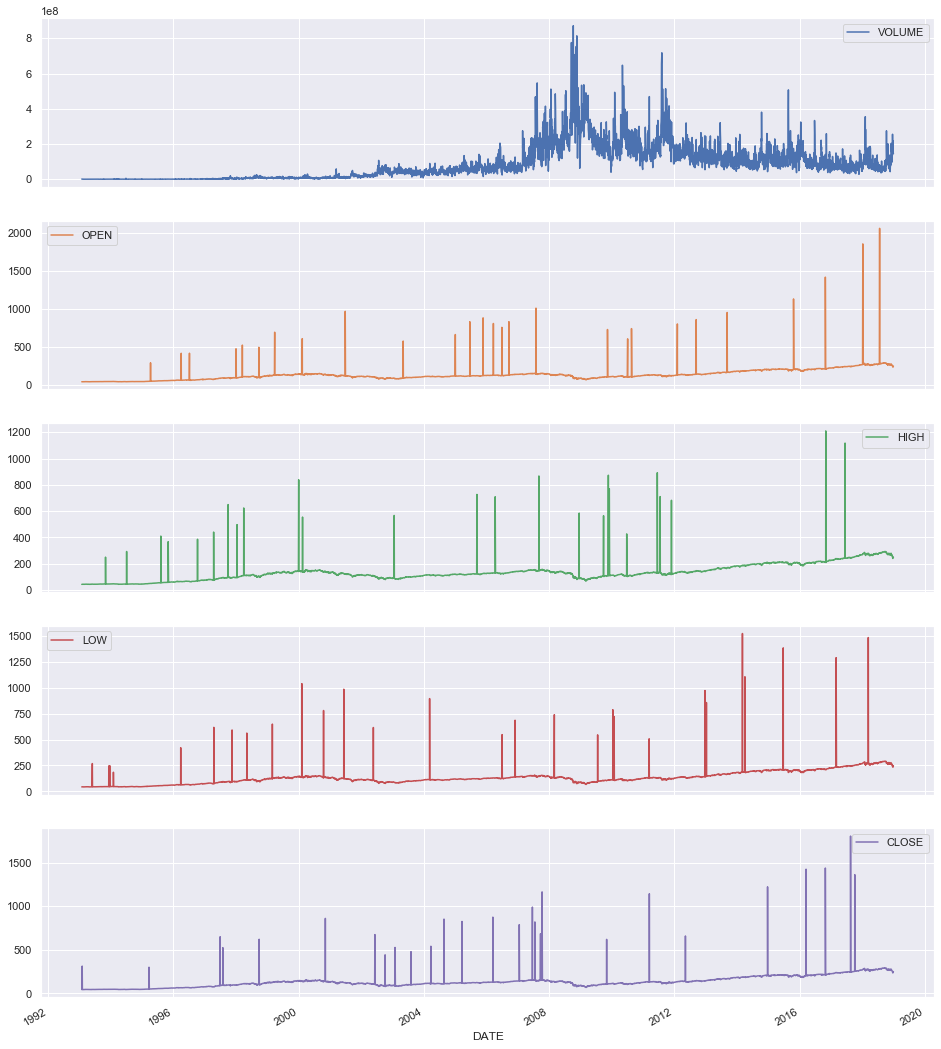

In [5]:
fig = data.plot(subplots=True, figsize=(16,20), sharex=True)

As you can see from the above plot, the columns Open, High, Low and Close have errors in them. Since I am not an expert on this data, nor do I know where the data came from and why there are significant errors in it, I assume it is a human made error (probably to test me ;D). A simple solution, which is sufficient for this task, is to check the difference between the value and it's lagged value and afterwards calculate the z-score. If the z-score is bigger than 2, it is considered as an outlier, which will be replaced by it's lagged value.

In [6]:
for i in range(1, len(data.columns)):
    values = data.iloc[:,i]

    #calculate the difference between y_t and y_(t-1) (dorpna, as the first value has no lagging value)
    diff = (values-values.shift(-1)).dropna().to_numpy()

    mean = np.mean(diff)
    std = np.std(diff)

    #all indexes with a z-socre greater than 3 are considered ouliers and are included in the list
    false_index = np.argwhere((diff-mean)/std>2)
    false_index = false_index.flatten()
    
    data.iloc[false_index,i] = data.iloc[false_index-1,i].values
    print("For column " + data.columns[i] + " " +  str(len(false_index)) + " values have been replaced.")

For column OPEN 27 values have been replaced.
For column HIGH 25 values have been replaced.
For column LOW 28 values have been replaced.
For column CLOSE 27 values have been replaced.


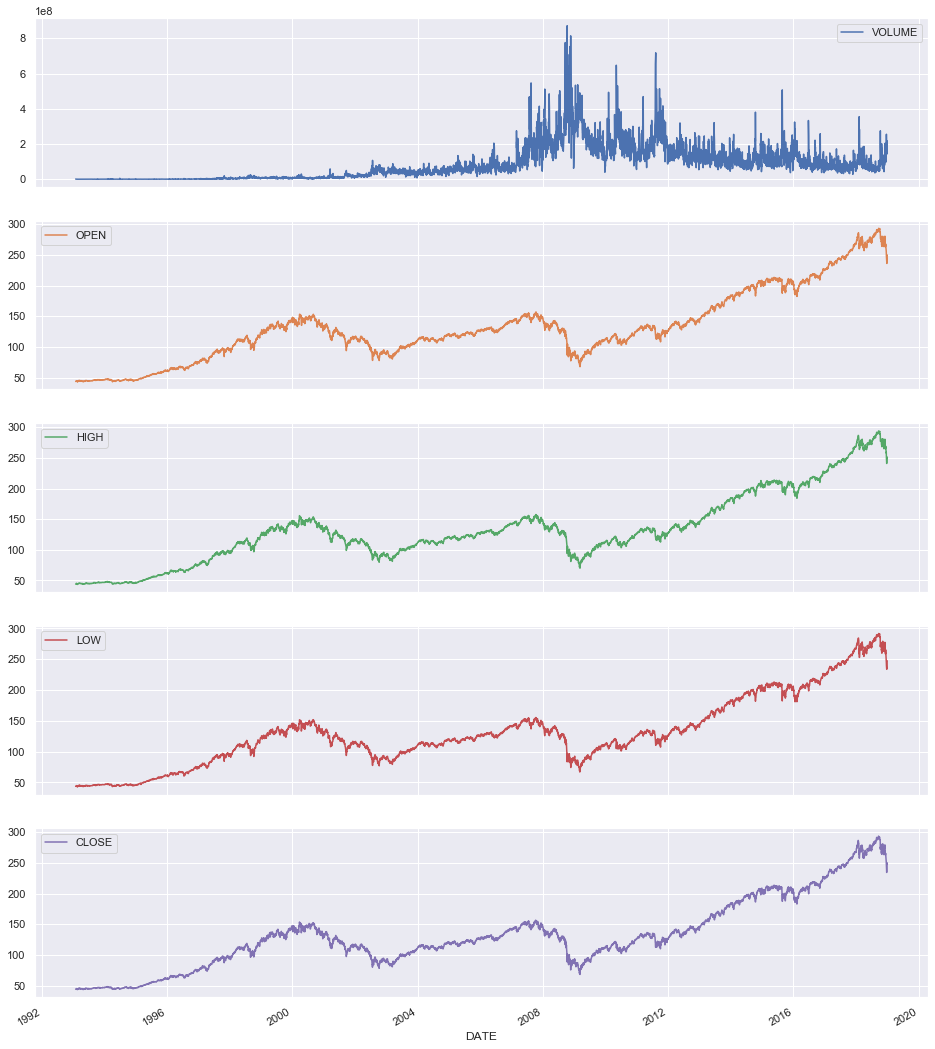

In [7]:
fig = data.plot(subplots=True, figsize=(16,20), sharex=True)

Much better! One check, looking at the descriptive statistics of the dataframe.

In [8]:
data.describe()

,VOLUME,OPEN,HIGH,LOW,CLOSE
count,6.528000e+03,6528.000000,6528.000000,6528.000000,6528.000000
mean,8.464678e+07,131.087569,131.857312,130.223934,131.079172
std,9.930732e+07,56.613516,56.786797,56.409509,56.604451
min,5.200000e+03,43.343783,43.531347,42.687527,43.406185
25%,6.739850e+06,95.840755,96.671866,94.953123,95.658757
50%,5.631290e+07,123.495010,124.150000,122.494918,123.415039
75%,1.245619e+08,149.320362,150.270037,148.219999,149.303484
max,8.715469e+08,293.090082,293.940040,291.810007,293.579985


## Explorative Data Analysis
It is important to know how the return behaves with the other variables. Therefore, the next plots will show this.

In [9]:
df = data.copy(deep=True)
#Calculate the close-to-close return
df["Return"]= (df["CLOSE"]-df["CLOSE"].shift(1))/df["CLOSE"].shift(1)*100
df.head()

,VOLUME,OPEN,HIGH,LOW,CLOSE,Return
DATE,,,,,,
1993-01-29,1003200.0,43.968916,43.968961,43.749988,43.937492,NaN
1993-02-01,480500.0,43.968944,44.249887,43.968655,44.250101,0.711487
1993-02-02,201300.0,44.218879,44.374910,44.124961,44.343823,0.211800
1993-02-03,529400.0,44.406412,44.843856,44.375026,44.343823,0.000000
1993-02-04,531500.0,44.968638,45.093704,44.874975,44.999975,1.479691


In [10]:
df["Return"].describe()

count    6527.000000
mean        0.033322
std         1.156401
min        -9.844706
25%        -0.456106
50%         0.052797
75%         0.563492
max        14.519763
Name: Return, dtype: float64

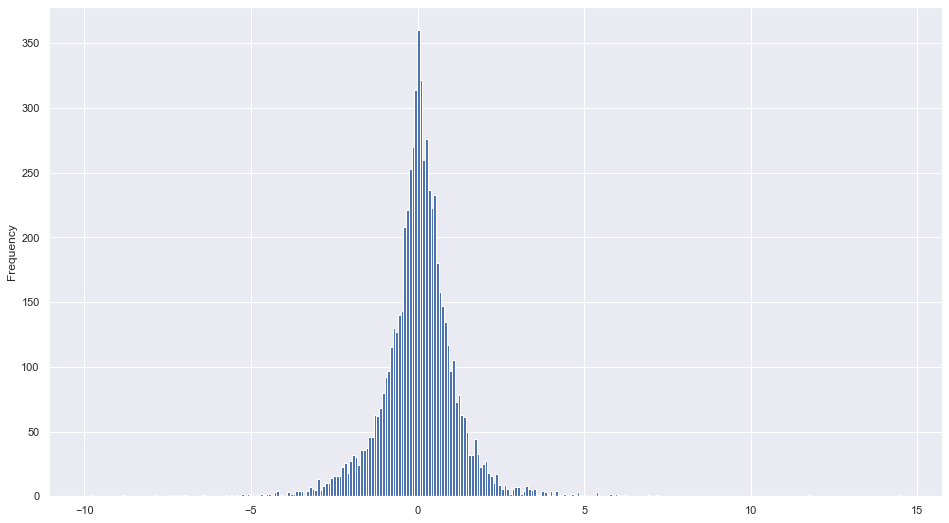

In [11]:
df["Return"].plot(kind="hist", figsize=(16,9), bins=300)

The histogram of the return shows that it is an almost perfect bell shaped curve. Next let's have a look how the return behaves over time. 

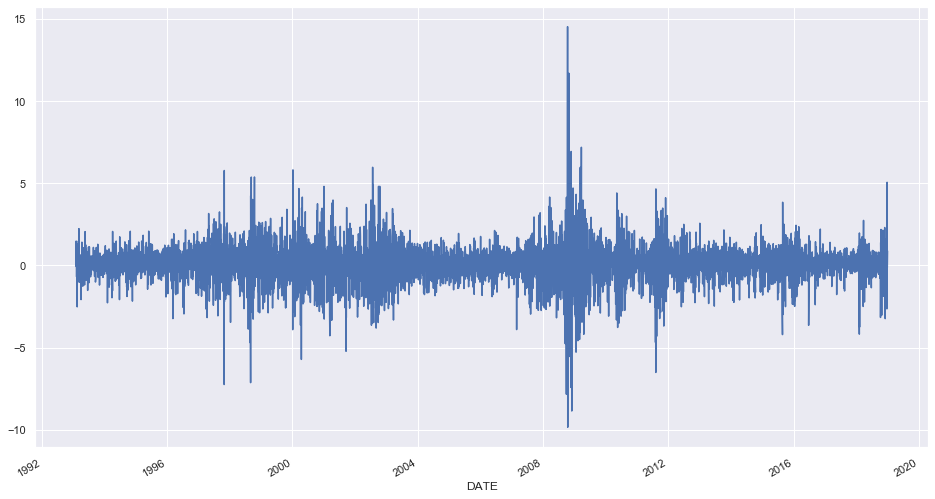

In [12]:
df["Return"].plot(kind="line", figsize=(16,9))

As expected, the time series looks like a white noise. In addition, the next plot shows how the return correlates with its past value.

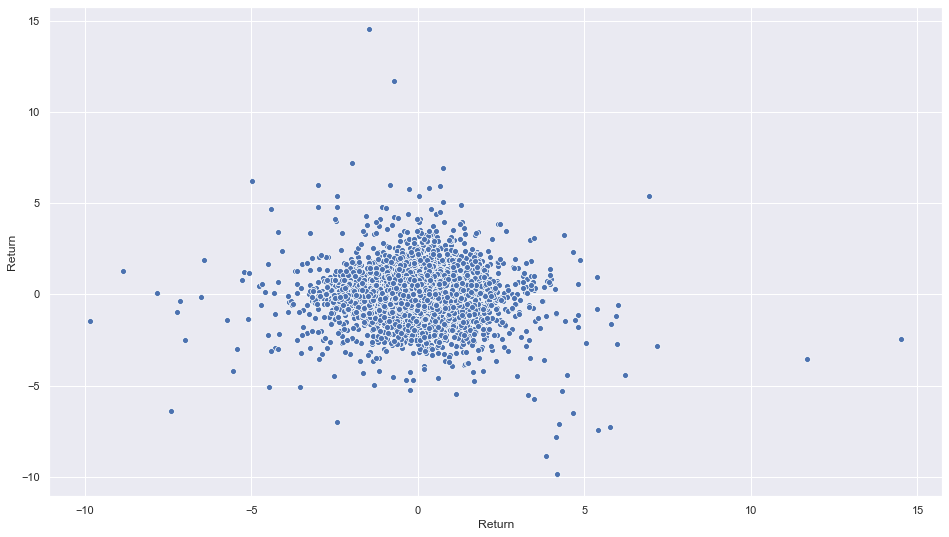

In [13]:
fig = plt.figure(figsize=(16,9))
sns.scatterplot(x=df["Return"], y=df["Return"].shift(1))

In [14]:
df.corr()

,VOLUME,OPEN,HIGH,LOW,CLOSE,Return
VOLUME,1.000000,0.199237,0.203464,0.193777,0.198270,-0.075677
OPEN,0.199237,1.000000,0.999895,0.999854,0.999763,-0.011411
HIGH,0.203464,0.999895,1.000000,0.999775,0.999855,-0.005345
LOW,0.193777,0.999854,0.999775,1.000000,0.999872,-0.002906
CLOSE,0.198270,0.999763,0.999855,0.999872,1.000000,0.005699
Return,-0.075677,-0.011411,-0.005345,-0.002906,0.005699,1.000000


Es scheint so als ob es kaum eine korrelation gibt. Daher schauen wir uns im nächsten schritt den ACF und PACF an.  

<Figure size 1152x648 with 0 Axes>

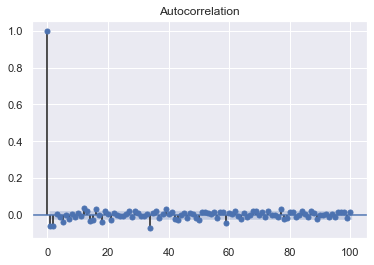

In [15]:
fig = plt.figure(figsize=(16,9))
acf = sm.graphics.tsa.plot_acf(df["Return"].dropna().values, lags=100)

<Figure size 1152x648 with 0 Axes>

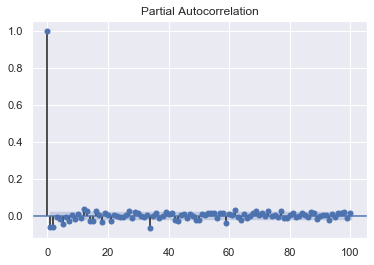

In [16]:
fig = plt.figure(figsize=(16,9))
pacf = sm.graphics.tsa.plot_pacf(df["Return"].dropna(), lags=100)

Now we check how the return behaves over time. Therefore, a boxplot for the months and a boxplot for the different years is created. 

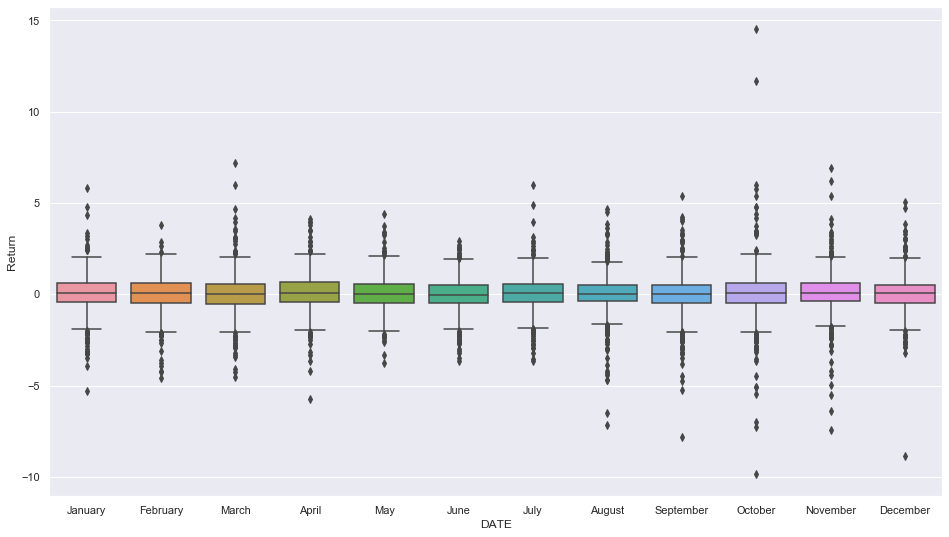

In [17]:
fig = plt.figure(figsize=(16,9))
sns.boxplot(data=df, x = df.index.month_name(), y = "Return")

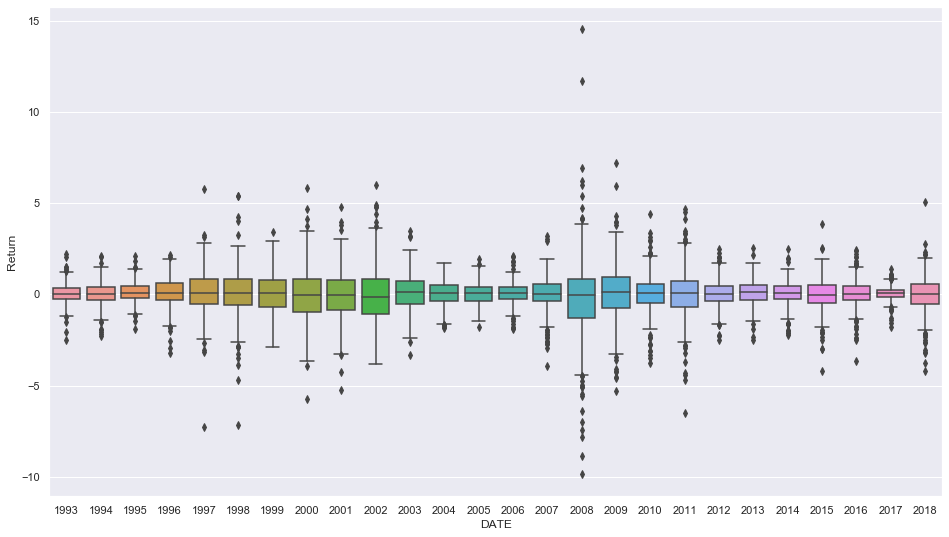

In [18]:
fig = plt.figure(figsize=(16,9))

sns.boxplot(data=df, x = df.index.year, y = "Return")

The monthly boxplot does not show a different behaviour between the months. The median return is around 0 for all of the months. From the yearly boxplot it can be seen that the years 2002 and 2008 were slightly more hectic than the other years. Again, the median return across all years is 0.

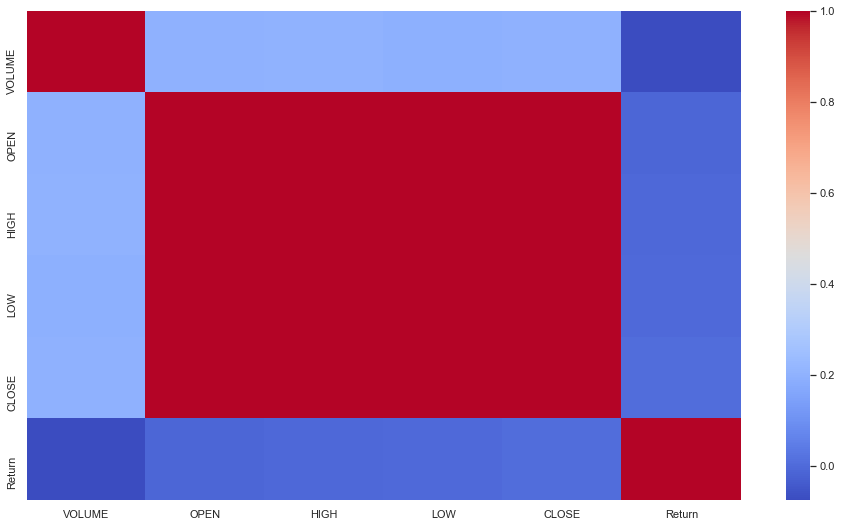

In [19]:
fig = plt.figure(figsize=(16,9))
sns.heatmap(df.corr(), cmap='coolwarm')

Finally, the correlation plot shows that the open, high, low, close and volume hardly correlate with the return.

## Feature Engineering

Now let's add lagging features of the features we already have.

In [20]:
# adding lagging features for all existing columns
for col in df.columns.values:
    for i in range(1,31):
        df[col+"-"+str(i)] = df[col].shift(i)
df.head()

,VOLUME,OPEN,HIGH,LOW,CLOSE,Return,VOLUME-1,VOLUME-2,VOLUME-3,VOLUME-4,...,Return-21,Return-22,Return-23,Return-24,Return-25,Return-26,Return-27,Return-28,Return-29,Return-30
DATE,,,,,,,,,,,,,,,,,,,,,
1993-01-29,1003200.0,43.968916,43.968961,43.749988,43.937492,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,480500.0,43.968944,44.249887,43.968655,44.250101,0.711487,1003200.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-02,201300.0,44.218879,44.374910,44.124961,44.343823,0.211800,480500.0,1003200.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-03,529400.0,44.406412,44.843856,44.375026,44.343823,0.000000,201300.0,480500.0,1003200.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-04,531500.0,44.968638,45.093704,44.874975,44.999975,1.479691,529400.0,201300.0,480500.0,1003200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In addition, technical indicators are added as features.

In [21]:
volume = df["VOLUME"]
open = df["OPEN"]
high = df["HIGH"]
low = df["LOW"]
close = df["CLOSE"]

#adding technical indicators from ta
df["AwesomeOscillator"] = ta.momentum.AwesomeOscillatorIndicator(high, low).awesome_oscillator()
df["Williams"] = ta.momentum.WilliamsRIndicator(high, low, close).williams_r()
df["Ichimoku_senkou_a"] = ta.trend.IchimokuIndicator(high, low).ichimoku_a()
df["Ichimoku_senkou_b"] = ta.trend.IchimokuIndicator(high, low).ichimoku_b()
df["Ichimoku_kijun"] = ta.trend.IchimokuIndicator(high, low).ichimoku_base_line() 
df["Ichimoku_tenkan"] = ta.trend.IchimokuIndicator(high, low).ichimoku_conversion_line()

lagging_t = [2,3,5,10,15,20,30]
for lag in lagging_t:
    df["ROC-"+str(lag)] = ta.momentum.ROCIndicator(close, window = lag).roc()
    df["RSI-"+str(lag)] = ta.momentum.RSIIndicator(close, window = 14).rsi()
    df["ATR-"+str(lag)] = ta.volatility.AverageTrueRange(high, low, close, window=lag).average_true_range()
    df["CCI-"+str(lag)] = ta.trend.CCIIndicator(high, low, close, window=lag).cci()
    df["EMA-"+str(lag)] = ta.trend.EMAIndicator(close, window = lag).ema_indicator()

df.tail(n=5)

,VOLUME,OPEN,HIGH,LOW,CLOSE,Return,VOLUME-1,VOLUME-2,VOLUME-3,VOLUME-4,...,ROC-20,RSI-20,ATR-20,CCI-20,EMA-20,ROC-30,RSI-30,ATR-30,CCI-30,EMA-30
DATE,,,,,,,,,,,,,,,,,,,,,
2018-12-24,147311588.0,239.039843,240.835650,234.270065,234.340087,-2.642306,255345633.0,252053377.0,214992763.0,134515094.0,...,-10.981910,18.936170,5.635112,-206.027708,258.254158,-16.456264,18.936170,5.128009,-266.530203,262.233463
2018-12-26,218485360.0,235.970122,246.180016,233.760044,246.180020,5.052457,147311588.0,255345633.0,252053377.0,214992763.0,...,-7.970088,36.362705,5.974355,-135.754623,257.104240,-11.369491,36.362705,5.371074,-186.425415,261.197757
2018-12-27,186267342.0,242.570068,248.289858,238.959903,248.070033,0.767736,218485360.0,147311588.0,255345633.0,252053377.0,...,-7.574479,38.630666,6.142135,-98.961632,256.243840,-8.988501,38.630666,5.503037,-141.707847,260.350807
2018-12-28,153100189.0,249.580012,251.400015,246.449935,247.749900,-0.129049,186267342.0,218485360.0,147311588.0,255345633.0,...,-9.771383,38.381153,6.082532,-68.333446,255.434893,-8.935634,38.381153,5.484605,-103.625933,259.537845
2018-12-31,144299370.0,249.560072,250.189982,247.470097,249.919950,0.875903,153100189.0,186267342.0,218485360.0,147311588.0,...,-8.781661,41.155678,5.914400,-57.490498,254.909660,-7.505629,41.155678,5.392448,-89.755156,258.917336


For the next step we convert cyclical variables such as day of week, month and day of year to a trigonometric function. This way, the cyclical behaviour is maintained in the data.

In [22]:
month = df.index.month

# Day Of Year
doy = df.index.dayofyear

# Day Of Week
dow = df.index.dayofweek

year = df.index.year

# convert cyclic features to a trigonometric function
df['mnth_sin'] = np.sin((month-1)*(2.*np.pi/len(month.unique())))
df['mnth_cos'] = np.cos((month-1)*(2.*np.pi/len(month.unique())))

df['doy_sin'] = np.sin((doy-1)*(2.*np.pi/len(doy.unique())))
df['doy_cos'] = np.cos((doy-1)*(2.*np.pi/len(doy.unique())))

df['dow_sin'] = np.sin((dow-1)*(2.*np.pi/len(dow.unique())))
df['dow_cos'] = np.cos((dow-1)*(2.*np.pi/len(dow.unique())))

df["year"] = year

df.head()

,VOLUME,OPEN,HIGH,LOW,CLOSE,Return,VOLUME-1,VOLUME-2,VOLUME-3,VOLUME-4,...,ATR-30,CCI-30,EMA-30,mnth_sin,mnth_cos,doy_sin,doy_cos,dow_sin,dow_cos,year
DATE,,,,,,,,,,,,,,,,,,,,,
1993-01-29,1003200.0,43.968916,43.968961,43.749988,43.937492,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,1.000000,0.463550,0.886071,-0.587785,-0.809017,1993
1993-02-01,480500.0,43.968944,44.249887,43.968655,44.250101,0.711487,1003200.0,NaN,NaN,NaN,...,0.0,NaN,NaN,0.5,0.866025,0.508671,0.860961,-0.951057,0.309017,1993
1993-02-02,201300.0,44.218879,44.374910,44.124961,44.343823,0.211800,480500.0,1003200.0,NaN,NaN,...,0.0,NaN,NaN,0.5,0.866025,0.523416,0.852078,0.000000,1.000000,1993
1993-02-03,529400.0,44.406412,44.843856,44.375026,44.343823,0.000000,201300.0,480500.0,1003200.0,NaN,...,0.0,NaN,NaN,0.5,0.866025,0.538005,0.842942,0.951057,0.309017,1993
1993-02-04,531500.0,44.968638,45.093704,44.874975,44.999975,1.479691,529400.0,201300.0,480500.0,1003200.0,...,0.0,NaN,NaN,0.5,0.866025,0.552435,0.833556,0.587785,-0.809017,1993


The last step is to remove the return from the feature dataframe and put it into its own variable.

In [23]:
df["y"] = df["Return"].shift(1)

df = df.dropna() 

y = df["y"]
X = df.iloc[:,:-1]

In [24]:
X.head()

,VOLUME,OPEN,HIGH,LOW,CLOSE,Return,VOLUME-1,VOLUME-2,VOLUME-3,VOLUME-4,...,ATR-30,CCI-30,EMA-30,mnth_sin,mnth_cos,doy_sin,doy_cos,dow_sin,dow_cos,year
DATE,,,,,,,,,,,,,,,,,,,,,
1993-03-18,59300.0,45.218851,45.499999,45.218786,45.312631,0.624992,21800.0,30800.0,310800.0,643600.0,...,0.420156,80.219796,44.789403,0.866025,0.5,0.965740,0.259512,0.587785,-0.809017,1993
1993-03-19,66900.0,45.281311,45.281325,45.031369,45.031342,-0.620774,59300.0,21800.0,30800.0,310800.0,...,0.415526,51.904095,44.805012,0.866025,0.5,0.970064,0.242850,-0.587785,-0.809017,1993
1993-03-22,183400.0,44.593812,44.874839,44.562569,44.781205,-0.555472,66900.0,59300.0,21800.0,30800.0,...,0.417301,7.891140,44.803476,0.866025,0.5,0.981306,0.192452,-0.951057,0.309017,1993
1993-03-23,55200.0,44.906382,44.937525,44.812587,44.875028,0.209515,183400.0,66900.0,59300.0,21800.0,...,0.408601,24.837616,44.808092,0.866025,0.5,0.984474,0.175531,0.000000,1.000000,1993
1993-03-24,37200.0,44.812589,45.062506,44.593894,44.875031,0.000006,55200.0,183400.0,66900.0,59300.0,...,0.410602,20.235209,44.812411,0.866025,0.5,0.987349,0.158559,0.951057,0.309017,1993


The question arises as to whether it is better to shuffle during the train test split or not. The model tends to become more robust when shuffled, as it is also trained with newer values. Since it is not clear at the moment which strategy is better, the results are carried out with both versions. Additionally we scale the data in both cases.

In [35]:
def split_data(X, y, shuffle):
    """
    get X, y and split it into train, test and evaluate data set with 90, 10, 10 split and scale it with a
    standard scaler and returns the data sets. If shuffle is set to true it will shuffle the data set
    
    Parameters
    ----------
    X: pandas Dataframe
    y: list
    shuffle: boolean

    Returns
    -------
    X_train: ndarray array
    y_train: list
    X_test: ndarray array
    y_test: list
    X_val: ndarray array
    y_val: list
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle = shuffle)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111, random_state=1) # 0.1111 x 0.9 ≈ 0.1

    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    return(X_train, y_train, X_test, y_test, X_val, y_val)

#Train test split without shuffle
X_train, y_train, X_test, y_test, X_val, y_val = split_data(X,y,False)

#Train test split with shuffle
X_train_shuffle, y_train_shuffle, X_test_shuffle, y_test_shuffle, X_val_shuffle, y_val_shuffle = split_data(X,y,True)

## Models
To compare the performance of the models, the mean squared error (MSE) is calculated based on the test set. Afterwards we can compare them.

### Naive Model
To begin with, we take the naïve model to create a baseline. For naïve forecasts, we simply set all forecasts to be the value of the last observation. That is,

$$\hat{y}_{T+h|T} = y_{T}.$$



In [26]:
def naive_model(X, y_train, y_test, shuffle):
    """
    calculates the MSE for a naive model
    
    Parameters
    ----------
    X: pandas ndarray array
    y_train: list
    y_test: list
    shuffle: boolean
        if shuflle is set to True, the print message will differ
    """
    mse_naive_train = mean_squared_error(y_train, X["Return"].loc[y_train.index])
    mse_naive_test = mean_squared_error(y_test, X["Return"].loc[y_test.index])
    if shuffle:
        print("Performance on shuffled train: " + str(mse_naive_train) + " performance on shuffled test: " + str(mse_naive_test))
    else:
        print("Performance on train: " + str(mse_naive_train) + " performance on test: " + str(mse_naive_test))

naive_model(X, y_train, y_test, False)
naive_model(X, y_train_shuffle, y_test_shuffle, True)

Performance on train: 3.071160553230065 performance on test: 1.2860909177447695
Performance on shuffled train: 2.9137729274233326 performance on shuffled test: 2.724367247993145


### Random Forest

In addition, a random forest regressor is trained. This gives us another model with to compare our results. This model is also very useful to compute the feature importance (later).

In [27]:
def random_forest(X_train, y_train, X_test, y_test, shuffle):
    """
    calculates the MSE for a naive model
    
    Parameters
    ----------
    X_train: ndarray array
    y_train: list
    X_test: ndarray array
    y_test: list
    shuffle: boolean
        if shuflle is set to True, the print message will differ
    
    Returns
    -------
    regr: Random Forest Model
    """
    regr = RandomForestRegressor()
    regr.fit(X_train, y_train)

    y_pred_train = regr.predict(X_train)
    y_pred_test = regr.predict(X_test)

    mse_RF_train = mean_squared_error(y_pred_train, y_train)
    mse_RF_test = mean_squared_error(y_pred_test, y_test)
    if shuffle:
        print("Performance on shuffled train: " + str(mse_RF_train) + " performance on shuffled test: " + str(mse_RF_test))
    else:
        print("Performance on train: " + str(mse_RF_train) + " performance on test: " + str(mse_RF_test))
    return regr

rf = random_forest(X_train, y_train, X_test, y_test, False)
rf_shuffle = random_forest(X_train_shuffle, y_train_shuffle, X_test_shuffle, y_test_shuffle, True)

Performance on train: 0.002372750654611681 performance on test: 0.002058415911074687
Performance on shuffled train: 0.003128928537761194 performance on shuffled test: 0.0036739259917113005


### Neural Net

Now that we have two base models, we can create a neural network and compare them. As the task states, I should create a model that shows the loss according to epochs, only a neural network would be suitable ;) Therefore let's try to find a suitable NN. The NN has a reduce learning rate on plateau and early stopping callbacks included.

DISCLAIMER: Due to my lack of computing power, I implemented a simple function to find the optimal neural network architecture. If I had more computing power, I would have used the GridSearchCV function from sklearn to find the optimal solution.

Normal dataset
Number of layers: 2, Neurons: 32, Dropout: 0.2, Loss: 0.12821813620053804
Number of layers: 2, Neurons: 32, Dropout: 0.4, Loss: 0.08069971304673415
Number of layers: 2, Neurons: 64, Dropout: 0.2, Loss: 0.059297165824816776
Number of layers: 2, Neurons: 128, Dropout: 0.2, Loss: 0.0555298991386707
Number of layers: 2, Neurons: 256, Dropout: 0.2, Loss: 0.023752751854749826
Shuffled dataset
Number of layers: 2, Neurons: 32, Dropout: 0.2, Loss: 0.07952348764126117
Number of layers: 2, Neurons: 64, Dropout: 0.2, Loss: 0.0582185462804941
Number of layers: 2, Neurons: 128, Dropout: 0.2, Loss: 0.05115544938124143


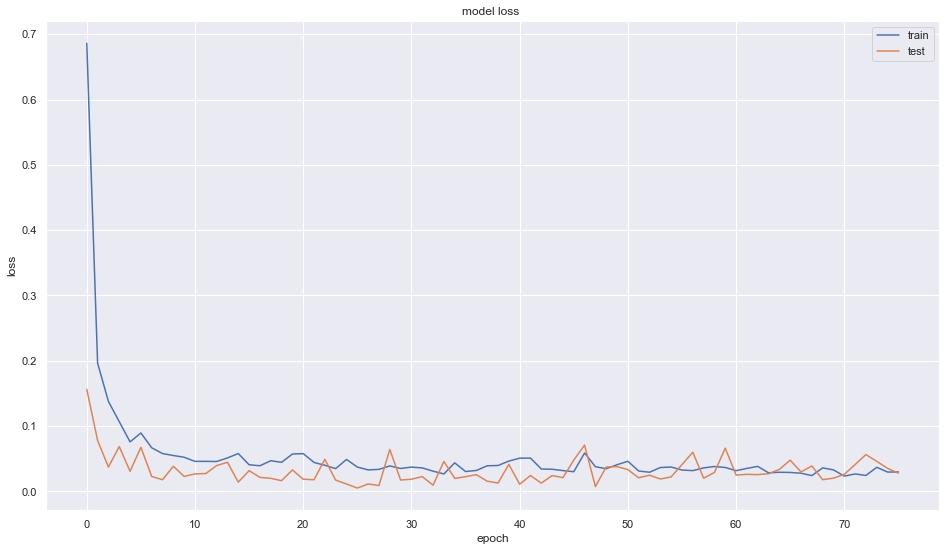

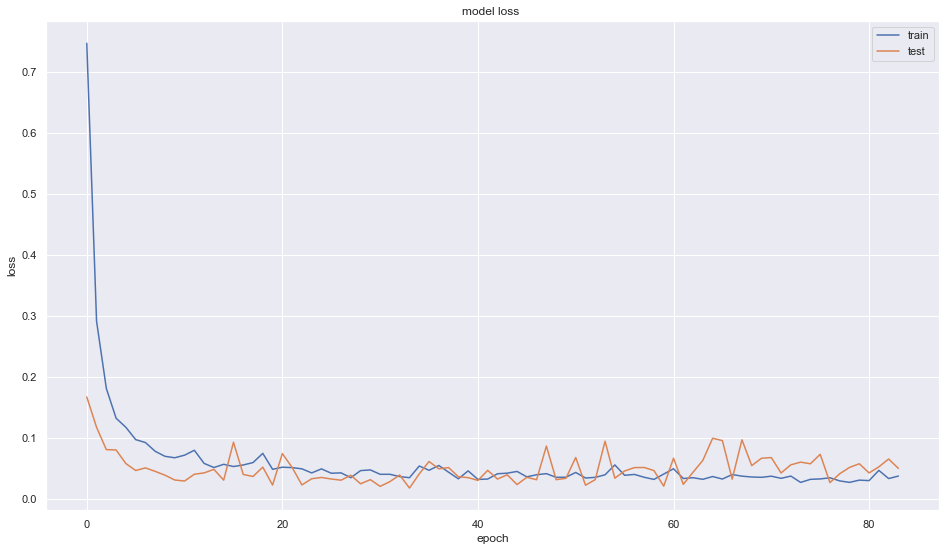

In [28]:
def create_model(X_train, y_train, X_test, y_test, X_val, y_val, number_of_layers=3, number_of_neurons=64, dropout=0.5):
    """
    Create, trains and evaluate model. The architecture is based on the number_of_layers, number_of_neurons and dropout. 
    The neural net will be trained with X_train and y_train, evaluated with X_test, y_test and validated with X_val, y_val
    
    Parameters
    ----------
    X_train: ndarray array
    y_train: list
    X_test: ndarray array
    y_test: list
    X_val: ndarray array
    y_val: list
    number_of_layers: int
    number_of_neurons: int
    dropout: float
    
    Returns
    -------
    loss: float
    hist: keras history
    model: kears model
    """
    model = Sequential()
    model.add(Dense(number_of_neurons, activation='relu', input_shape =(X_train.shape[1],)))
    model.add(Dropout(dropout))
    for i in range(number_of_layers):
        model.add(Dense(number_of_neurons, activation='relu'))
        model.add(Activation('relu'))
        model.add(Dropout(dropout))

    model.add(Dense(units = 1))


    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    early_stoping = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)

    model.compile(optimizer='adam', loss='mse')

    hist = model.fit(X_train, y_train, epochs=5000, batch_size=64, validation_data=(X_val, y_val),
              callbacks=[reduce_lr, early_stoping], verbose = 0)

    loss = model.evaluate(X_test, y_test, verbose=0)
    return loss, hist, model

def find_best_model(layers, neurons, dropouts, X_train, y_train, X_test, y_test, X_val, y_val):
    """
    Tries to find a best model in the limits of the given lists of layers, neurons and dropouts. The actual model will
    be trained in the function create_model() with the given data sets
    
    Parameters
    ----------
    layers: list of int
    neurons: list of int
    dropouts: list of float
    X_train: ndarray array
    y_train: list
    X_test: ndarray array
    y_test: list
    X_val: ndarray array
    y_val: list

    
    Returns
    -------
    best_loss: float
    best_hist: keras history
    best_model: kears model
    """
    best_loss = 99999999
    best_hist = ""
    best_model = ""

    for layer in layers:
        for neuron in neurons:
            for dropout in dropouts:
                loss, hist, model = create_model(X_train, y_train, X_test, y_test, X_val, y_val, number_of_layers=layer, 
                                          number_of_neurons=neuron, dropout=dropout)
                if loss < best_loss:
                    best_loss = loss
                    best_hist = hist
                    best_model = model
                    print("Number of layers: "+str(layer) + ", Neurons: " + str(neuron) + 
                          ", Dropout: " + str(dropout) + ", Loss: " +  str(loss))
    plot_history(best_hist)
    return best_loss, best_hist, best_model

def plot_history(history):
    """
    Get's a keras history and plots it
    
    Parameters
    ----------
    history: keras history
    """
    plt.figure(figsize=(16,9))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss ')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    
layers = [2,3,4]
neurons = [32, 64, 128, 256]
dropouts = [0.2, 0.4]

print("Normal dataset")
best_loss, best_hist, best_model = find_best_model(layers, neurons, dropouts, X_train, y_train, X_test, y_test, X_val, y_val)
print("Shuffled dataset")
best_loss_shuffle, best_hist_shuffle, best_model_shuffle = find_best_model(layers, neurons, dropouts, X_train_shuffle, y_train_shuffle, 
                                                                           X_test_shuffle, y_test_shuffle, X_val_shuffle, y_val_shuffle)

## Feature Importance

Text(0.5, 0, 'Random Forest Feature Importance')

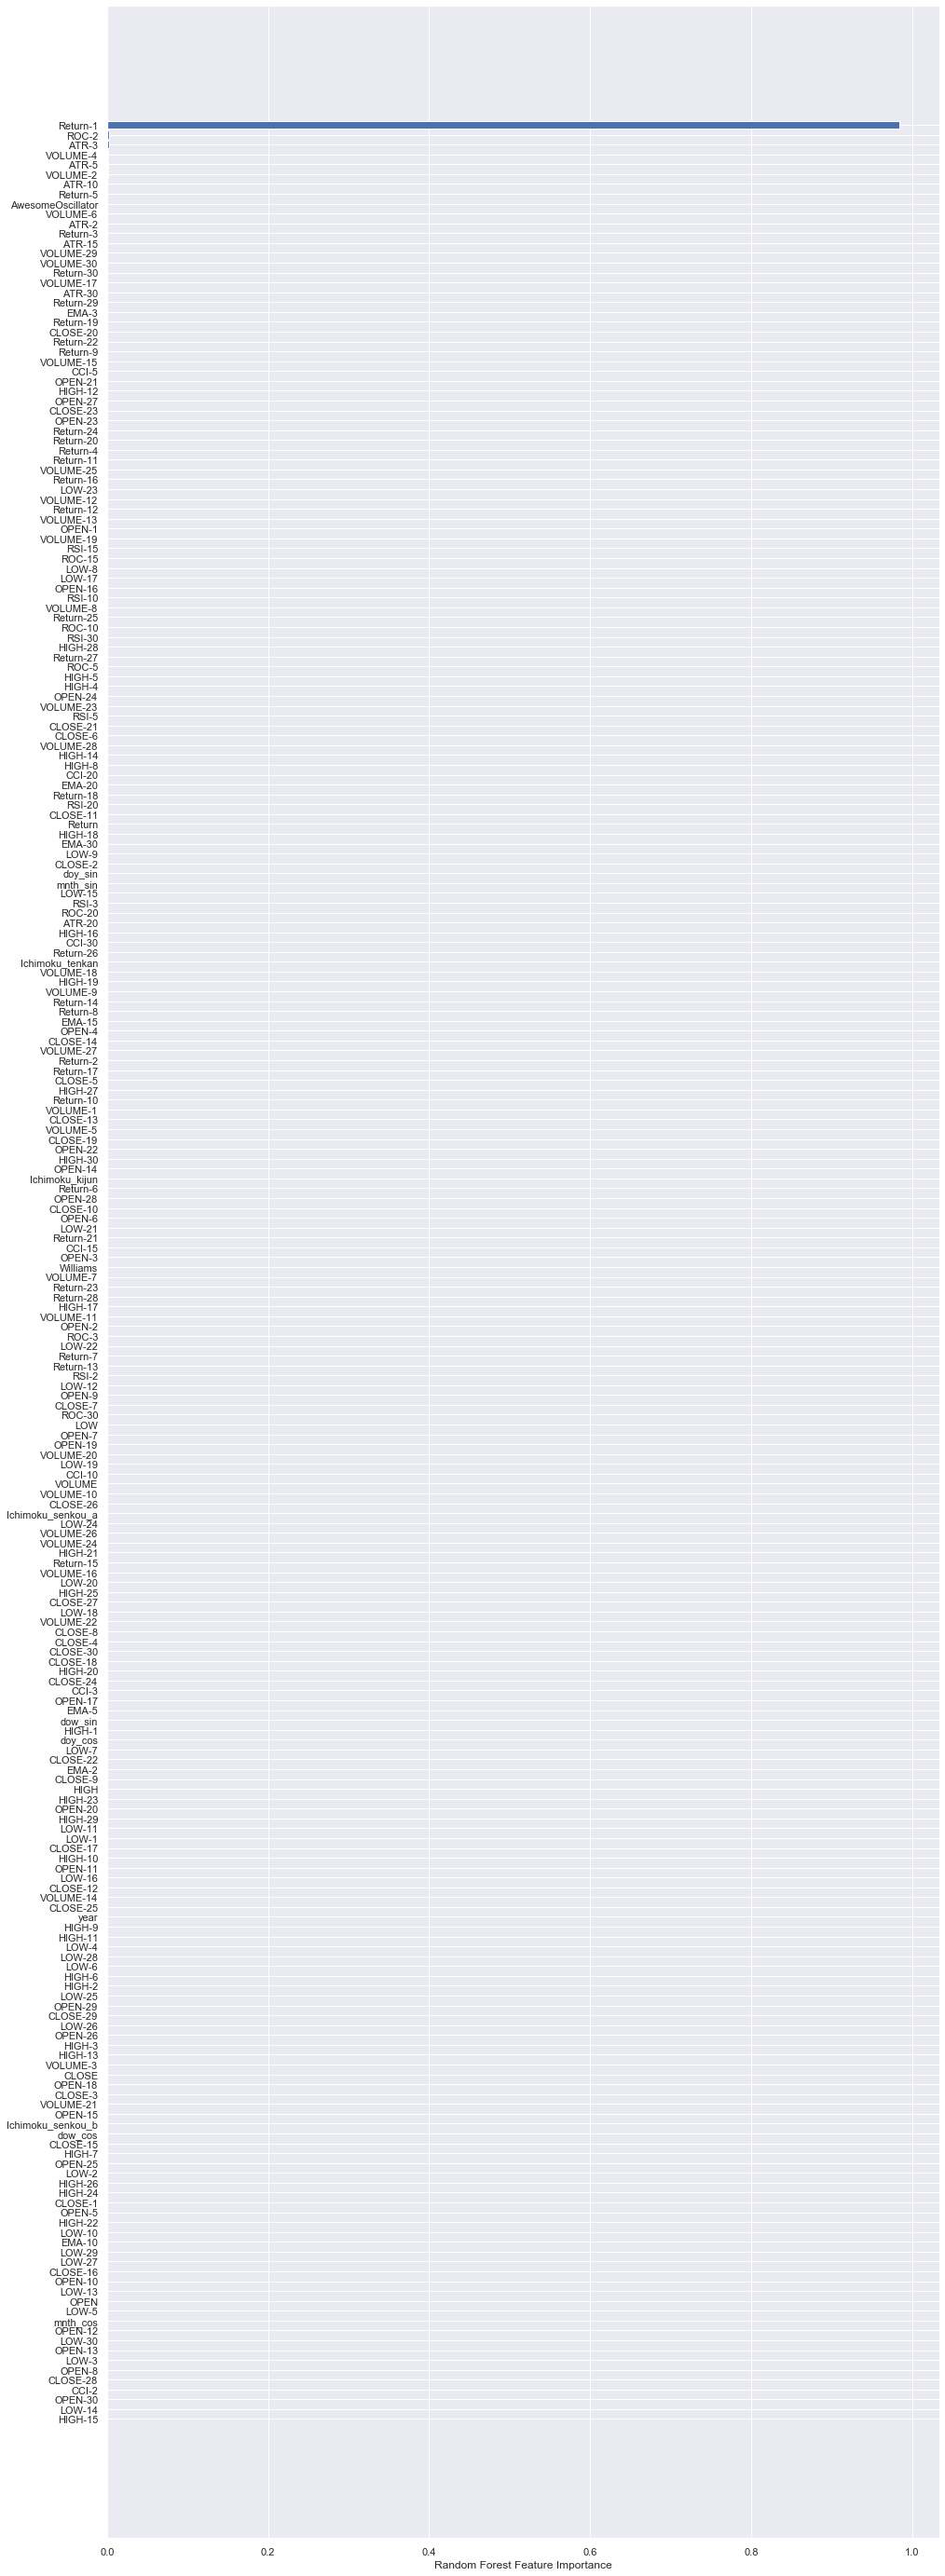

In [29]:
# sort columns based on feature importance
sorted_idx = rf_shuffle.feature_importances_.argsort()

# crate figure
fig = plt.figure(figsize=(16,50))
plt.barh(X.columns[sorted_idx], rf_shuffle.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

As can be seen in the plot, most of the features are unimportant. Therefore, the RF and the NN are trained and evaluated again with the smaller dataset.

In [30]:
# get the 10 most important features and create a new data set based on them
important_columns = X.columns[sorted_idx[-10:]].tolist()
X_new = X[important_columns]
X_new.head()

,VOLUME-6,AwesomeOscillator,Return-5,ATR-10,VOLUME-2,ATR-5,VOLUME-4,ATR-3,ROC-2,Return-1
DATE,,,,,,,,,,
1993-03-18,194400.0,0.595809,-0.273547,0.402363,30800.0,0.384884,643600.0,0.376106,0.000518,-0.620595
1993-03-19,70900.0,0.585829,-1.028320,0.390253,21800.0,0.364159,310800.0,0.344491,0.000338,0.624992
1993-03-22,643600.0,0.474149,0.484582,0.398105,59300.0,0.385082,30800.0,0.385918,-1.172798,-0.620774
1993-03-23,310800.0,0.355782,-0.000198,0.373927,66900.0,0.339330,21800.0,0.309386,-0.347121,-0.555472
1993-03-24,30800.0,0.293128,-0.620595,0.383395,183400.0,0.365186,59300.0,0.362461,0.209520,0.209515


Random Forest
Performance on train: 0.001602813286267955 performance on test: 0.006037714877357562
Performance on shuffled train: 0.001470122720724833 performance on shuffled test: 0.0020913386963552637
NN on normal dataset
Number of layers: 2, Neurons: 32, Dropout: 0.2, Loss: 0.037658066084751717
Number of layers: 2, Neurons: 64, Dropout: 0.2, Loss: 0.02883738001378683
Number of layers: 2, Neurons: 128, Dropout: 0.2, Loss: 0.010070710411438576
Number of layers: 2, Neurons: 128, Dropout: 0.4, Loss: 0.008220525131775782
Number of layers: 2, Neurons: 256, Dropout: 0.2, Loss: 0.004218052768936524
NN on shuffled dataset
Number of layers: 2, Neurons: 32, Dropout: 0.2, Loss: 0.11213104009628296
Number of layers: 2, Neurons: 64, Dropout: 0.2, Loss: 0.05647139895420808
Number of layers: 2, Neurons: 128, Dropout: 0.2, Loss: 0.02474213278064361
Number of layers: 2, Neurons: 256, Dropout: 0.2, Loss: 0.011806660122596301
Number of layers: 2, Neurons: 256, Dropout: 0.4, Loss: 0.005063264246743459


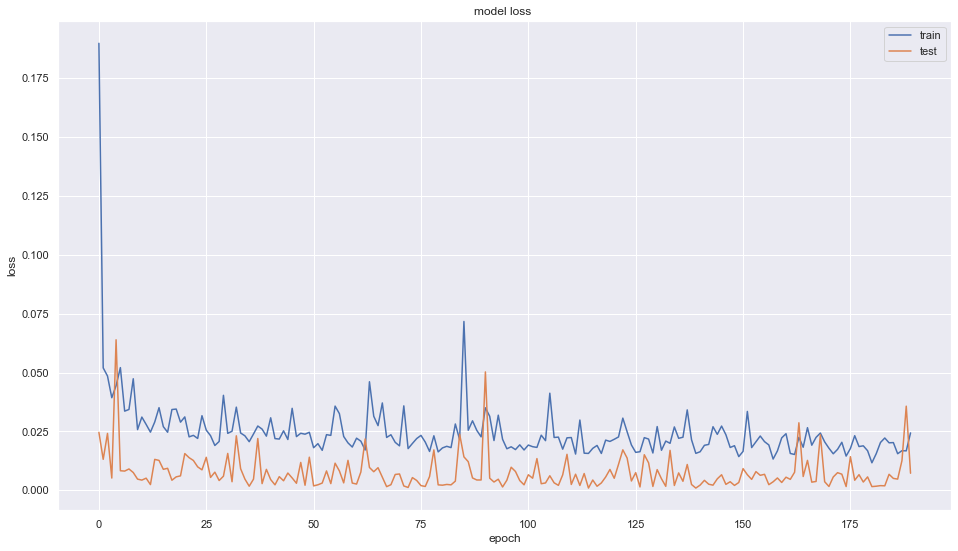

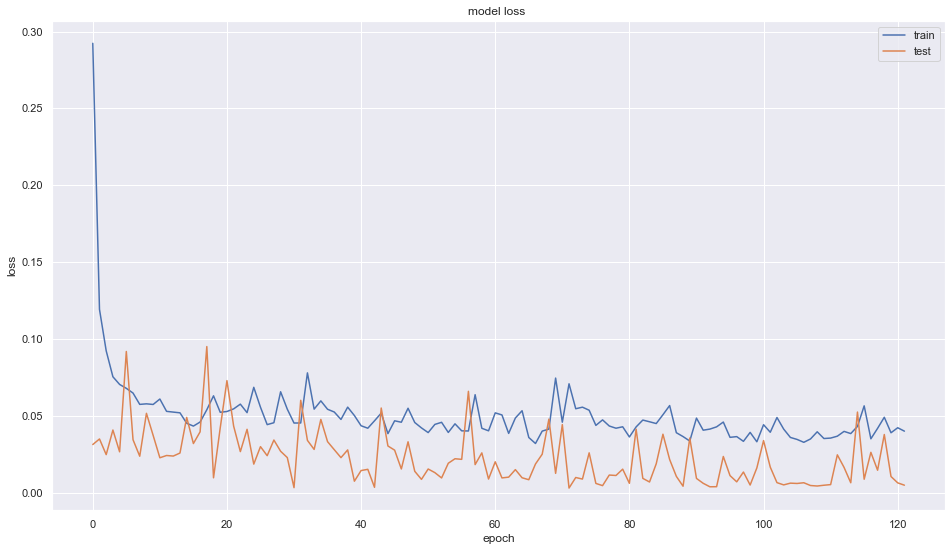

In [31]:
#Train test split without shuffle
X_train, y_train, X_test, y_test, X_val, y_val = split_data(X_new,y,False)

#Train test split with shuffle
X_train_shuffle, y_train_shuffle, X_test_shuffle, y_test_shuffle, X_val_shuffle, y_val_shuffle = split_data(X_new,y,True)

print("Random Forest")
rf = random_forest(X_train, y_train, X_test, y_test, False)
rf_shuffle = random_forest(X_train_shuffle, y_train_shuffle, X_test_shuffle, y_test_shuffle, True)

print("NN on normal dataset")
best_loss, best_hist, best_model = find_best_model(layers, neurons, dropouts, X_train, y_train, X_test, y_test, X_val, y_val)
print("NN on shuffled dataset")
best_loss_shuffle, best_hist_shuffle, best_model_shuffle = find_best_model(layers, neurons, dropouts, X_train_shuffle, y_train_shuffle, 
                                                                           X_test_shuffle, y_test_shuffle, X_val_shuffle, y_val_shuffle)

With the smaller dataset, the performance of both the RF and the NN could be improved.

## Residual Analysis

The most important thing about the model is that it predicts the correct direction of the return, i.e. positive or negative. Therefore, the confusion matrix for the NN and the RF is shown here

In [32]:
def compute_confusion_matrix(model, X_test, y_test):
    """
    Computes and prints the confusion matrix based on a model and X, y datasets
    
    Parameters
    ----------
    model: trained RF or NN
    X_test: ndarray array
    y_test: list
    """
    y_pred_test = model.predict(X_test)
    
    # check if y_pred_test is instance of np.ndarray
    if isinstance(y_pred_test, np.ndarray):
        y_pred_test = y_pred_test.flatten()
    
    confusion_matrix = pd.DataFrame()
    confusion_matrix = pd.DataFrame(columns = ["Actual Positive", "Actual Negative"], 
                                    index = ["Predicted Positive", "Predicted Negative"])

    confusion_matrix.iloc[0,0] =  np.sum(np.where((y_pred_test>0) & (y_test.values>0), 1, 0)) #TP
    confusion_matrix.iloc[1,0] =  np.sum(np.where((y_pred_test<0) & (y_test.values>0), 1, 0)) #FN
    confusion_matrix.iloc[0,1] =  np.sum(np.where((y_pred_test>0) & (y_test.values<0), 1, 0)) #FP
    confusion_matrix.iloc[1,1] =  np.sum(np.where((y_pred_test<0) & (y_test.values<0), 1, 0)) #TN

    print(confusion_matrix)

print("Random Forest Confusion Matrix")
compute_confusion_matrix(rf_shuffle, X_test_shuffle, y_test_shuffle)

print("\n\nNeural Network Confusion Matrix")
compute_confusion_matrix(best_model, X_test, y_test)

Random Forest Confusion Matrix
                   Actual Positive Actual Negative
Predicted Positive             330               0
Predicted Negative               1             317


Neural Network Confusion Matrix
                   Actual Positive Actual Negative
Predicted Positive             339               0
Predicted Negative              13             295


The random forest has an almost perfect accurcay, only one value could not be classified correctly. Furthermore, the prediction is plotted against the real value. the better these correlate, the better our model is.

Text(0.5, 0, 'y true')

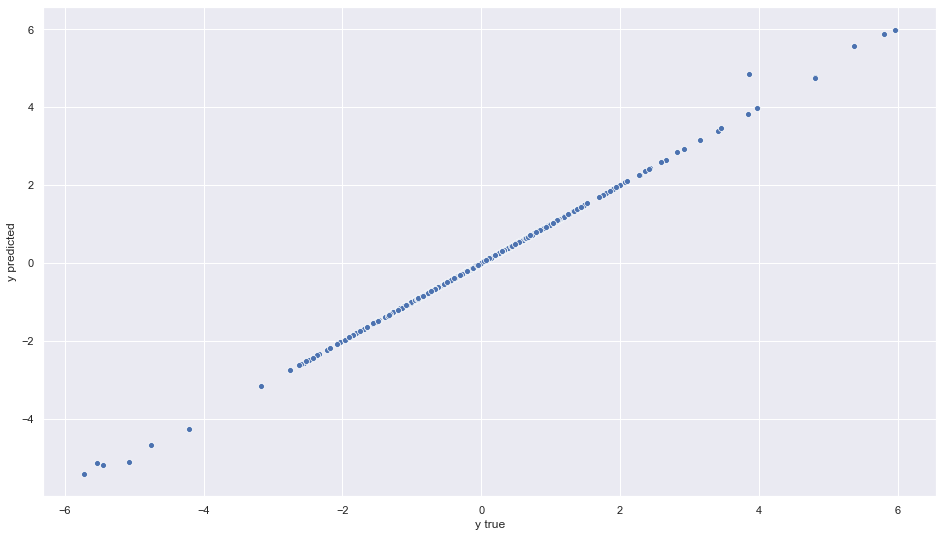

In [33]:
y_pred = rf_shuffle.predict(X_test_shuffle)

plt.figure(figsize=(16,9))
sns.scatterplot(y_test_shuffle, y_pred)
plt.ylabel("y predicted")
plt.xlabel("y true")

Also here it shows, that it has an extremly good predictive power.

## Summary

* The best result was achieved by the random forest with shuffled data.
* It has an almost perfect accuracy as shown in the confusion matrix
* Neural Net a bit worse than the Random Forest